In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback
from gymnasium import spaces
import torch

## Load Traffic Environment

In [3]:
# Add the `src` folder to the Python path
sys.path.append(os.path.join(os.path.abspath('..'), 'src'))


current_working_directory = os.getcwd()
src_path = os.path.join(current_working_directory, 'src')

if src_path not in sys.path:
    sys.path.append(src_path)
import environment_gym as env_gym
print("Import successful")

Import successful


## Create Evaluation and Test Function

In [3]:
def evaluate_model(log_path):
    """
    Reads the mean reward from the evaluation log and plots it to monitor convergence.

    Args:
    - log_path (str): Path to the directory containing the log file.
    """
    # Find the monitor CSV file generated by EvalCallback
    monitor_file = os.path.join(log_path, 'evaluations.npz')

    if not os.path.isfile(monitor_file):
        print("Error: Log file not found.")
        return

    # Load evaluation results
    results = np.load(monitor_file)
    mean_rewards = results['results'].mean(axis=1)  # Mean reward per evaluation

    # Plot the mean reward to observe convergence
    plt.plot(mean_rewards)
    plt.xlabel('Evaluation Step (x1000 timesteps)')
    plt.ylabel('Mean Reward')
    plt.title('Model Convergence')
    plt.show()

In [4]:
def test_model(model_path, env, num_episodes):
    """
    Evaluates the model over a specified number of episodes, records rewards for each episode,
    and plots the rewards.

    Args:
    - model_path (str): Path to the saved model.
    - env (gym.Env): The environment to evaluate the model on.
    - num_episodes (int): Total number of episodes to run the evaluation.

    Returns:
    - episode_rewards (list): List of total rewards for each episode.
    """
    # Load the model
    model = PPO.load(model_path)

    # Initialize a list to store rewards for each episode
    episode_rewards = []

    # Run the model for the specified number of episodes
    for episode in range(num_episodes):
        obs, info = env.reset()
        episode_reward = 0  

        while True:  # Run until the episode ends
            action, _states = model.predict(obs, deterministic=True)
            action = action.item()
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward  # Accumulate reward

            # Check if the episode is done
            if terminated or truncated:
                episode_reward = round(episode_reward)
                episode_rewards.append(episode_reward)  # Record total reward for the episode
                break  # Exit the loop to start a new episode

    # Calculate average reward
    reward_ave = round(sum(episode_rewards) / num_episodes)
    print(f"Average reward of {num_episodes} episodes is {reward_ave}.")
    
    # Plot the episode rewards
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards per Episode')
    plt.show()

    return episode_rewards

## Baseline PPO Agent

In [5]:
# Initialize and vectorize the environment for parallel processing
env = env_gym.TrafficEnvironment()
check_env(env, warn=True)
env.reset()

eval_env = Monitor(env_gym.TrafficEnvironment())
check_env(eval_env, warn=True)
eval_env.reset()

# Define the PPO model with MlpPolicy (a policy network that works well with continuous environments)
model = PPO("MlpPolicy", env, verbose=1, device="cpu")

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/ppo_baseline_model',
    log_path='./logs/baseline_results',
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Train the PPO model
total_timesteps = 50000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=1851.20 +/- 563.23
Episode length: 216.00 +/- 55.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 216      |
|    mean_reward     | 1.85e+03 |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-9589.16 +/- 13687.47
Episode length: 1359.20 +/- 1368.58
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.36e+03  |
|    mean_reward     | -9.59e+03 |
| time/              |           |
|    total_timesteps | 2000      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.17e+03  |
|    ep_rew_mean     | -1.18e+04 |
| time/              |           |
|    fps             | 381       |
|

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.54e+03  |
|    ep_rew_mean     | -1.53e+04 |
| time/              |           |
|    fps             | 239       |
|    iterations      | 6         |
|    time_elapsed    | 51        |
|    total_timesteps | 12288     |
----------------------------------
Eval num_timesteps=13000, episode_reward=-11983.98 +/- 7389.58
Episode length: 1598.60 +/- 738.65
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.6e+03     |
|    mean_reward          | -1.2e+04    |
| time/                   |             |
|    total_timesteps      | 13000       |
| train/                  |             |
|    approx_kl            | 0.026288975 |
|    clip_fraction        | 0.299       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.712      |
|    explained_variance   | -2.85e-05   |
|    learning_rate        | 0.0003      |
|    l

Eval num_timesteps=24000, episode_reward=-10669.00 +/- 10359.23
Episode length: 1467.00 +/- 1035.86
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.47e+03  |
|    mean_reward     | -1.07e+04 |
| time/              |           |
|    total_timesteps | 24000     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.16e+03  |
|    ep_rew_mean     | -9.59e+03 |
| time/              |           |
|    fps             | 259       |
|    iterations      | 12        |
|    time_elapsed    | 94        |
|    total_timesteps | 24576     |
----------------------------------
Eval num_timesteps=25000, episode_reward=-8364.84 +/- 11293.43
Episode length: 1236.80 +/- 1129.13
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.24e+03     |
|    mean_reward          | -8.36e+03    |
| time/                   |       

Eval num_timesteps=35000, episode_reward=-6685.14 +/- 9623.51
Episode length: 1068.80 +/- 962.14
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 1.07e+03      |
|    mean_reward          | -6.69e+03     |
| time/                   |               |
|    total_timesteps      | 35000         |
| train/                  |               |
|    approx_kl            | 1.2807985e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.429        |
|    explained_variance   | 0.182         |
|    learning_rate        | 0.0003        |
|    loss                 | 7.49e+03      |
|    n_updates            | 170           |
|    policy_gradient_loss | -0.000131     |
|    value_loss           | 1.66e+04      |
-------------------------------------------
Eval num_timesteps=36000, episode_reward=-4380.10 +/- 6020.00
Episode length: 838.20 +/- 601.86
---------------

Eval num_timesteps=47000, episode_reward=-18033.64 +/- 16273.34
Episode length: 2203.20 +/- 1627.53
---------------------------------
| eval/              |          |
|    mean_ep_length  | 2.2e+03  |
|    mean_reward     | -1.8e+04 |
| time/              |          |
|    total_timesteps | 47000    |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.03e+03  |
|    ep_rew_mean     | -7.54e+03 |
| time/              |           |
|    fps             | 254       |
|    iterations      | 23        |
|    time_elapsed    | 185       |
|    total_timesteps | 47104     |
----------------------------------
Eval num_timesteps=48000, episode_reward=-6243.86 +/- 7543.70
Episode length: 1024.80 +/- 754.02
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1.02e+03     |
|    mean_reward          | -6.24e+03    |
| time/                   |              |


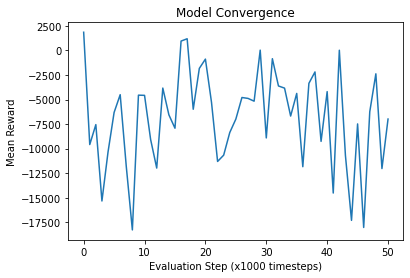

In [6]:
evaluate_model(log_path='./logs/baseline_results')

Average reward of 100 episodes is -5718.


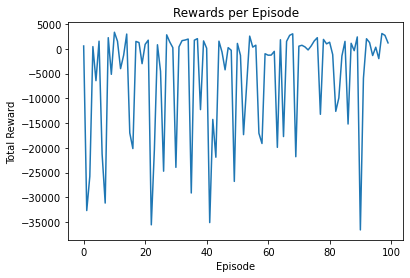

[560,
 -32650,
 -25747,
 438,
 -6439,
 1531,
 -21249,
 -31140,
 2238,
 -5160,
 3334,
 1524,
 -4009,
 -1309,
 2969,
 -16990,
 -20140,
 1480,
 1252,
 -3009,
 889,
 1734,
 -35535,
 -20350,
 809,
 -4539,
 -24709,
 2811,
 1374,
 228,
 -23935,
 389,
 1637,
 1765,
 1960,
 -29109,
 1729,
 2042,
 -12280,
 1584,
 113,
 -35080,
 -14260,
 -21889,
 1533,
 -658,
 -4249,
 231,
 -308,
 -26769,
 1077,
 -1330,
 -17329,
 -7460,
 2553,
 334,
 722,
 -17050,
 -19119,
 -1004,
 -1298,
 -1275,
 -522,
 -19900,
 1821,
 -17719,
 1490,
 2710,
 3018,
 -21789,
 523,
 703,
 367,
 -240,
 569,
 1581,
 2234,
 -13230,
 1886,
 988,
 1322,
 -1170,
 -12630,
 -9919,
 -1448,
 1493,
 -15189,
 1101,
 -384,
 2387,
 -36560,
 -5950,
 2022,
 1249,
 -1367,
 314,
 -1989,
 3079,
 2703,
 1186]

In [7]:
# Model testing
model_path = './logs/ppo_baseline_model/best_model.zip'
env_test = env_gym.TrafficEnvironment()
num_episodes = 100
test_model(model_path=model_path, env=env, num_episodes=num_episodes)

## Finetune PPO Agent

In [8]:
# Initialize and vectorize the environment
env = env_gym.TrafficEnvironment()
eval_env = Monitor(env_gym.TrafficEnvironment())

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/ppo_finetune_model',
    log_path='./logs/finetune_results',
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Define the PPO model with MlpPolicy
model = PPO(
    "MlpPolicy", 
    env, 
    verbose=1,
    device = "cpu",
    learning_rate=2.5e-4,         
    n_steps=4096,               
    batch_size=128,              
    gae_lambda=0.95,            
    gamma=0.99,                 
    clip_range=0.1,
    clip_range_vf=0.1,
    n_epochs=20,
    ent_coef=0.005,
    target_kl=0.01
)

# Train the PPO model
total_timesteps = 50000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=-4842.36 +/- 8640.61
Episode length: 864.80 +/- 851.95
----------------------------------
| eval/              |           |
|    mean_ep_length  | 865       |
|    mean_reward     | -4.84e+03 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-1705.04 +/- 4898.21
Episode length: 555.00 +/- 485.70
----------------------------------
| eval/              |           |
|    mean_ep_length  | 555       |
|    mean_reward     | -1.71e+03 |
| time/              |           |
|    total_timesteps | 2000      |
----------------------------------
New best mean reward!
Eval num_timesteps=3000, episode_reward=-12981.26 +/- 12862.26
Episode length: 1674.60 +/- 1280.58
---------------------------------
| eval/              |          |
|    mean_ep_le

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 948       |
|    ep_rew_mean     | -8.51e+03 |
| time/              |           |
|    fps             | 288       |
|    iterations      | 4         |
|    time_elapsed    | 56        |
|    total_timesteps | 16384     |
----------------------------------
Eval num_timesteps=17000, episode_reward=-1654.00 +/- 4251.99
Episode length: 562.60 +/- 423.04
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 563          |
|    mean_reward          | -1.65e+03    |
| time/                   |              |
|    total_timesteps      | 17000        |
| train/                  |              |
|    approx_kl            | 0.0030904054 |
|    clip_fraction        | 0.1          |
|    clip_range           | 0.1          |
|    clip_range_vf        | 0.1          |
|    entropy_loss         | -1.08        |
|    explained_variance   | 0.00188   

Eval num_timesteps=31000, episode_reward=-5695.26 +/- 14112.42
Episode length: 964.80 +/- 1409.23
---------------------------------
| eval/              |          |
|    mean_ep_length  | 965      |
|    mean_reward     | -5.7e+03 |
| time/              |          |
|    total_timesteps | 31000    |
---------------------------------
Eval num_timesteps=32000, episode_reward=-4179.84 +/- 6482.44
Episode length: 812.20 +/- 645.91
----------------------------------
| eval/              |           |
|    mean_ep_length  | 812       |
|    mean_reward     | -4.18e+03 |
| time/              |           |
|    total_timesteps | 32000     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 940       |
|    ep_rew_mean     | -8.15e+03 |
| time/              |           |
|    fps             | 279       |
|    iterations      | 8         |
|    time_elapsed    | 117       |
|    total_timesteps | 32768     |
--------

Eval num_timesteps=46000, episode_reward=-11878.72 +/- 16019.27
Episode length: 1585.40 +/- 1601.20
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1.59e+03    |
|    mean_reward          | -1.19e+04   |
| time/                   |             |
|    total_timesteps      | 46000       |
| train/                  |             |
|    approx_kl            | 0.001054408 |
|    clip_fraction        | 0.0244      |
|    clip_range           | 0.1         |
|    clip_range_vf        | 0.1         |
|    entropy_loss         | -0.92       |
|    explained_variance   | 0.00062     |
|    learning_rate        | 0.00025     |
|    loss                 | 9.47e+03    |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.000568   |
|    value_loss           | 1.96e+04    |
-----------------------------------------
Eval num_timesteps=47000, episode_reward=-2721.28 +/- 5667.95
Episode length: 670.00 +/- 564.31
------

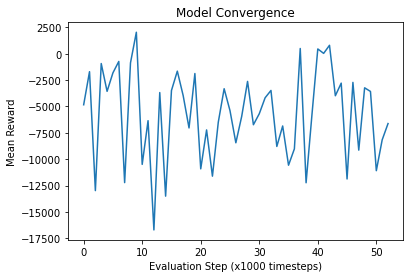

In [9]:
evaluate_model(log_path='./logs/finetune_results')

Average reward of 200 episodes is -6530.


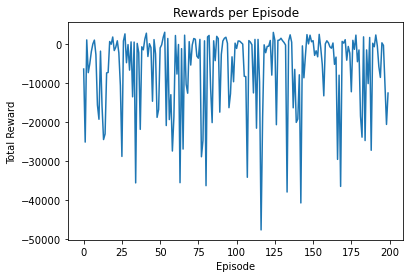

[-6324,
 -25077,
 1146,
 -7254,
 -4980,
 -1891,
 95,
 1095,
 -2648,
 -15538,
 -19218,
 -1732,
 -15773,
 -24424,
 -22985,
 -7325,
 -7199,
 732,
 37,
 1892,
 -1585,
 -715,
 915,
 -2178,
 -10550,
 -28754,
 867,
 2694,
 -4704,
 -60,
 -6605,
 636,
 -13460,
 594,
 -35545,
 247,
 -2124,
 -21809,
 -620,
 -1399,
 1355,
 2869,
 -3110,
 168,
 -826,
 -14599,
 1223,
 -2450,
 -18730,
 -16715,
 -916,
 -118,
 1800,
 3112,
 -20829,
 1515,
 -19299,
 -12909,
 -27369,
 -18600,
 2276,
 -7619,
 -33,
 -35490,
 -1096,
 -26865,
 2360,
 -10259,
 -12535,
 703,
 -5309,
 -148,
 1504,
 1322,
 -3016,
 -3548,
 1279,
 -28839,
 -24645,
 909,
 -36260,
 1923,
 2287,
 -11160,
 -20075,
 912,
 -4175,
 2060,
 1493,
 -17390,
 -2563,
 857,
 1560,
 1834,
 270,
 -16245,
 -12640,
 -3192,
 -9590,
 315,
 -1046,
 873,
 830,
 457,
 70,
 -8194,
 -8270,
 -34109,
 969,
 576,
 -108,
 -12455,
 1274,
 -21509,
 1270,
 -9635,
 -47610,
 -18750,
 -114,
 -2139,
 -523,
 -462,
 1002,
 -7889,
 3076,
 1067,
 -20615,
 1034,
 1110,
 1571,
 961,
 485,

In [10]:
# Model testing
model_path = './logs/ppo_finetune_model/best_model.zip'
env_test = env_gym.TrafficEnvironment()
num_episodes = 200
test_model(model_path=model_path, env=env, num_episodes=num_episodes)

Training with parameters: {'batch_size': 64, 'clip_range': 0.2, 'gamma': 0.99, 'learning_rate': 0.0003, 'n_steps': 1024, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -7006.149000000004
New best model found with reward -7006.149000000004
Training with parameters: {'batch_size': 64, 'clip_range': 0.2, 'gamma': 0.99, 'learning_rate': 0.0003, 'n_steps': 2048, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -9065.453000000001
Training with parameters: {'batch_size': 64, 'clip_range': 0.2, 'gamma': 0.99, 'learning_rate': 0.0005, 'n_steps': 1024, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -4854.102
New best model found with reward -4854.102
Training with parameters: {'batch_size': 64, 'clip_range': 0.2, 'gamma': 0.99, 'learning_rate': 0.0005, 'n_steps': 2048, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -7577.493000000009
Training with parameters: {'batch_size': 64, 'clip_range': 0.2, 'gamma': 0.99, 'learning_rate': 0.0008, 'n_steps': 102

Mean reward for current parameters: -7572.496000000001
Training with parameters: {'batch_size': 128, 'clip_range': 0.2, 'gamma': 0.95, 'learning_rate': 0.0003, 'n_steps': 2048, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -4580.0509999999995
New best model found with reward -4580.0509999999995
Training with parameters: {'batch_size': 128, 'clip_range': 0.2, 'gamma': 0.95, 'learning_rate': 0.0005, 'n_steps': 1024, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -5710.463
Training with parameters: {'batch_size': 128, 'clip_range': 0.2, 'gamma': 0.95, 'learning_rate': 0.0005, 'n_steps': 2048, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -6191.647000000002
Training with parameters: {'batch_size': 128, 'clip_range': 0.2, 'gamma': 0.95, 'learning_rate': 0.0008, 'n_steps': 1024, 'policy': 'MlpPolicy'}
Mean reward for current parameters: -7707.857
Training with parameters: {'batch_size': 128, 'clip_range': 0.2, 'gamma': 0.95, 'learning_rate': 0.0008, 'n_s

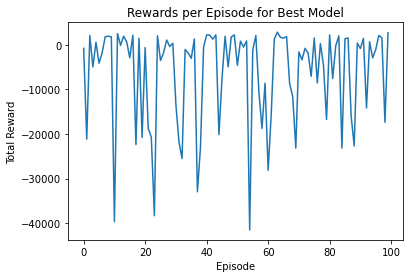

In [11]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
import numpy as np

param_grid = {
    'policy': ['MlpPolicy'],
    'learning_rate': [0.0003, 0.0005, 0.0008, 0.0001],
    'n_steps': [1024, 2048],
    'batch_size': [64, 128],
    'clip_range': [0.2, 0.1],
    'gamma': [0.99, 0.95]
}

env = env_gym.TrafficEnvironment()
eval_env = Monitor(env_gym.TrafficEnvironment())
best_reward = -float('inf')
best_params = None
best_model_path = "./best_model"
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    model = PPO(params['policy'], env, **{k: v for k, v in params.items() if k != 'policy'}, verbose=0)
    model.learn(total_timesteps=500000)
    obs, info = eval_env.reset()
    episode_rewards = []
    for _ in range(100):
        total_reward = 0
        while True:
            action, _ = model.predict(obs, deterministic=True)
            action =int(action)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            total_reward += reward
            if terminated or truncated:
                episode_rewards.append(total_reward)
                obs, info = eval_env.reset()
                break
    mean_reward = np.mean(episode_rewards)
    print(f"Mean reward for current parameters: {mean_reward}")

    if mean_reward > best_reward:
        best_reward = mean_reward
        best_params = params
        model.save(best_model_path)
        print(f"New best model found with reward {best_reward}")

print(f"Best parameters found: {best_params}")
print(f"Best reward: {best_reward}")

plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode for Best Model')
plt.show()


Training with parameters: {'policy': 'MlpPolicy', 'learning_rate': 0.0003, 'n_steps': 2048, 'batch_size': 64, 'gamma': 0.99, 'gae_lambda': 0.98, 'n_epochs': 20, 'ent_coef': 0.0, 'clip_range': 0.2, 'policy_kwargs': {'net_arch': {'pi': [128, 128], 'vf': [128, 128]}}}
Mean reward for the selected parameters: -4808.193


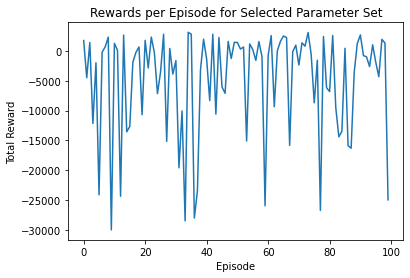

In [4]:
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import numpy as np

# Custom environment setup
env = env_gym.TrafficEnvironment()  # Make sure env_gym.TrafficEnvironment is correctly defined
eval_env = Monitor(env_gym.TrafficEnvironment())

params = {
    'policy': 'MlpPolicy',
    'learning_rate': 0.0003,
    'n_steps': 2048,
    'batch_size': 64,
    'gamma': 0.99,
    'gae_lambda': 0.98,
    'n_epochs': 20,
    'ent_coef': 0.0,
    'clip_range': 0.2,
    'policy_kwargs': {'net_arch': {'pi': [128, 128], 'vf': [128, 128]}}
}


# Train the model with the specified parameters
print(f"Training with parameters: {params}")
model = PPO(
    policy=params['policy'],
    env=env,
    learning_rate=params['learning_rate'],
    n_steps=params['n_steps'],
    batch_size=params['batch_size'],
    gamma=params['gamma'],
    gae_lambda=params['gae_lambda'],
    n_epochs=params['n_epochs'],
    ent_coef=params['ent_coef'],
    clip_range=params['clip_range'],
    policy_kwargs=params['policy_kwargs'],
    verbose=0
)

model.learn(total_timesteps=50000)

# Evaluate the model
obs, info = eval_env.reset()
episode_rewards = []
for _ in range(100):
    total_reward = 0
    while True:
        action, _ = model.predict(obs, deterministic=True)
        action = int(action)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        total_reward += reward
        if terminated or truncated:
            episode_rewards.append(total_reward)
            obs, info = eval_env.reset()
            break

# Calculate and display mean reward
mean_reward = np.mean(episode_rewards)
print(f"Mean reward for the selected parameters: {mean_reward}")

# Plotting rewards per episode
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode for Selected Parameter Set')
plt.show()
